In [1]:
import numpy as np
import copy
import matplotlib.patheffects as PathEffects

In [2]:
number_of_machines = 3
machines = [[] for _ in range(number_of_machines)]
tasks = {'0': 2, '1': 3, '2': 5, '3': 5, '4': 3, '5': 2, '6' : 9, '7': 5, '8' : 2, '9' : 15, '10' : 2}
tasks_gurobi = [2, 3, 5, 5, 3, 2, 9, 5, 2, 15, 2]
tasks_gurobi.sort()

In [3]:
def counting_current_objective_function_value(machines):

    obj_func_value = 0

    for machine in machines:
        
        completion_times_for_one_machine = 0
        current_completion_time = 0

        for task in machine:
            current_completion_time += task
            completion_times_for_one_machine += current_completion_time

        obj_func_value += completion_times_for_one_machine

    return obj_func_value

In [4]:
from gurobipy import *

In [5]:
m_s_s_p_o = Model('Make_span_scheduling_problem')

Restricted license - for non-production use only - expires 2023-10-25


In [6]:
matrix_of_variables = m_s_s_p_o.addMVar((number_of_machines, len(tasks_gurobi)), vtype=GRB.BINARY)

In [7]:
total_of_completion_dates = []

for id_row, row_of_variables in enumerate(matrix_of_variables):

    current_sum = []
    
    for index, variable in enumerate(row_of_variables):

      current_sum += [variable * tasks_gurobi[index]]
      total_of_completion_dates += [sum(current_sum) * variable]

In [8]:
m_s_s_p_o.setObjective(sum(total_of_completion_dates), GRB.MINIMIZE)

for j in range(len(tasks)):
    column_constraint = m_s_s_p_o.addConstr(sum([var for var in matrix_of_variables[:, j]]) == 1)

m_s_s_p_o.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 33 columns and 33 nonzeros
Model fingerprint: 0xf9669faf
Model has 198 quadratic objective terms
Variable types: 0 continuous, 33 integer (33 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 208.0000000
Presolve time: 0.00s
Presolved: 176 rows, 198 columns, 528 nonzeros
Variable types: 0 continuous, 198 integer (198 binary)

Root relaxation: objective 5.300000e+01, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   53.00000    0   20  208.00000   53.00000  74.5%     -    0s
H    0  

In [9]:
print(f'Total of completion times: {m_s_s_p_o.objVal}')

Total of completion times: 92.0


In [10]:
cell = 1
row = 1
machine_tasks = '1 MACHINE: '

for index, v in enumerate(m_s_s_p_o.getVars()):

    if cell == len(tasks_gurobi) + 1 and index < number_of_machines * len(tasks_gurobi):
        cell = 1
        row += 1
        machine_tasks += f'\n{row} MACHINE: '

    if index < number_of_machines * len(tasks_gurobi):
        machine_tasks += f' x{row}_{cell}: {int(v.x)}  '

    else:
        print(f'{v.varName} {v.x}')

    cell += 1

start = "\nComplexity:"
for task in tasks_gurobi:
    if task < 10:
        start += " " * 4 + str(task) + " " * 5
    else:
        start += " " * 4 + str(task) + " " * 4

print(start)
print(machine_tasks)


Complexity:    2         2         2         2         3         3         5         5         5         9         15    
1 MACHINE:  x1_1: 0   x1_2: 0   x1_3: 0   x1_4: 0   x1_5: 1   x1_6: 0   x1_7: 0   x1_8: 0   x1_9: 1   x1_10: 1   x1_11: 0  
2 MACHINE:  x2_1: 1   x2_2: 0   x2_3: 0   x2_4: 1   x2_5: 0   x2_6: 1   x2_7: 0   x2_8: 0   x2_9: 0   x2_10: 0   x2_11: 1  
3 MACHINE:  x3_1: 0   x3_2: 1   x3_3: 1   x3_4: 0   x3_5: 0   x3_6: 0   x3_7: 1   x3_8: 1   x3_9: 0   x3_10: 0   x3_11: 0  


In [11]:
def generating_starting_solution(machines, tasks):

    order_of_tasks = [[] for _ in range(len(machines))]

    for order, task in tasks.items():
        chosen_machine_number = np.random.randint(1, len(machines) + 1)
        machines[chosen_machine_number - 1] += [task]
        order_of_tasks[chosen_machine_number - 1] += [order]

    return order_of_tasks, machines

In [12]:
np.random.seed(69420)
order, starting_solution = generating_starting_solution(machines, tasks)
starting_objective_function_value = counting_current_objective_function_value(starting_solution)
print(order)
print(starting_solution)
print(starting_objective_function_value)

[[], ['1', '2', '6', '7', '8', '9'], ['0', '3', '4', '5', '10']]
[[], [3, 5, 9, 5, 2, 15], [2, 5, 3, 2, 2]]
158


In [13]:
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt

def make_span_visualization(job_ending_times_result, order_result, number_of_iterations, fig, ax, camera):

    colors = {'0': '#DC143C', '1': '#FFD700', '2':'#8A2BE2', '3':'#00FF00', '4':'#40E0D0', '5':'#FFA07A', '6':'#7B68EE', '7':'#006400', '8':'#B0E0E6', '9':'#DEB887', '10':'#D3D3D3',
                '11':'#DAF7A6', '12':'#FFA500', '13':'#FF1493'}

    bar_style = {'alpha': 1, 'lw':100, 'markeredgecolor':'black', 'markerfacecolor' :'black', 'markeredgewidth' : 3, 'solid_capstyle':'butt', 'solid_joinstyle' : 'miter'}
    bar_style_shadow = {'alpha': 0.85, 'lw':107, 'markeredgecolor':'black', 'markerfacecolor' :'black', 'markeredgewidth' : 3, 'solid_capstyle':'butt', 'solid_joinstyle' : 'miter'}
    # path_effects = [PathEffects.Stroke(linewidth=44, foreground='black'), PathEffects.Normal()]

    starting_index_color = 0

    for index, (machine, order_machine) in enumerate(zip(job_ending_times_result, order_result)):

        if len(machine) == 0:
            continue

        colors_for_machine = []

        for order in order_machine:

            colors_for_machine += [colors[order]]
        
        for indx, (task, order) in enumerate (zip(machine, order_machine)):

            if indx == 0:

                if int(order) < 10:
                    text_x_cordinate =  sum([0, task]) / 2 - 0.34

                else:
                    text_x_cordinate = sum([0, task]) / 2 - 0.74

                x_cordinates = [0 + 0.03, task - 0.045]
                x_cordinates_shadow = [-0.06, task]
            
            else:

                if int(order) < 10:
                    text_x_cordinate = (machine[indx] + machine[indx - 1]) / 2 - 0.34

                else:
                    text_x_cordinate = (machine[indx] + machine[indx - 1]) / 2 - 0.74

                x_cordinates = [machine[indx - 1] + 0.045, machine[indx] - 0.045]
                x_cordinates_shadow = [machine[indx - 1], machine[indx]]
                
            if indx == len(machine) - 1:
                x_cordinates_shadow = [machine[indx - 1], machine[indx] + 0.045]

            if indx == 0 and indx == len(machine) - 1:
                x_cordinates_shadow = [-0.06, task + 0.03]

            ax.plot(x_cordinates_shadow, [index] * 2, color='black', **bar_style_shadow)
            ax.plot(x_cordinates, [index] * 2, color=colors_for_machine[indx], **bar_style)

            text = ax.text(text_x_cordinate, index - 0.06, order, fontsize=40, color='white')
            text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='black')])
        
        starting_index_color += len(order_machine)

        
    max_time = lambda machines: sum([max(machine) for machine in machines])

    ax.set_ylim(-0.5, len(job_ending_times_result) - 0.5)
    ax.set_xticks(np.arange(max_time(job_ending_times_result) + 1))
    ax.set_title('Simulated annealing', fontsize=30)
    ax.set_xlabel('Starting and ending times', fontsize=20)
    ax.set_yticks(np.arange(0, len(job_ending_times_result)))
    ax.set_yticklabels(['1 machine', '2 machine', '3 machine'])
    ax.tick_params(labelsize=20)
    ax.grid(True)

    plt.tight_layout()
    plt.draw()

    camera.snap()

    # plt.savefig(f'test4/photo{number_of_iterations}.jpg')   
    

In [15]:
np.random.seed(42)

In [16]:
def job_ending_times(solution_result):

    ending_times = [[] for _ in range(len(solution_result))]

    for index, (machine, machine_times) in enumerate(zip(solution_result, ending_times)):

        current_ending_time = 0

        for job in machine:
            
            current_ending_time += job
            ending_times[index] += [current_ending_time]

    return ending_times

In [17]:
from celluloid import Camera  # ....... conda install celluloid
from IPython.display import HTML

In [18]:
def generating_new_solution(starting_solution, order,  starting_obj_func_val, *, T, alpha, epochs, stages, max_iterations_without_improvement, number_of_tasks, boundary_T=0.01):

    objective_function_values = []
    total_number_of_iterations = 0
    iterations_without_improvement = 0
    optimal_objective_function_value = starting_obj_func_val
    operating_solution = copy.deepcopy(starting_solution)
    operating_order = copy.deepcopy(order)

    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(28, 12))
    camera = Camera(fig)

    for stage in range(stages):

        T *= alpha 

        for epoch in range(epochs):

            can_do_first_option = True
            do_we_take_solution = False

            for machine in starting_solution:
                if len(machine) == number_of_tasks:
                    can_do_first_option = False

            if total_number_of_iterations % 2 == 0 and can_do_first_option:

                chosen_from_first_machine = False
                chosen_from_second_machine = False

                while not chosen_from_first_machine:
                            
                    index_of_chosen_first_machine = np.random.randint(0, len(operating_solution))

                    if len(operating_solution[index_of_chosen_first_machine]) > 0:

                        index_of_job_from_first_machine = np.random.randint(0, len(operating_solution[index_of_chosen_first_machine]))
                        job_from_first_machine = copy.deepcopy(operating_solution[index_of_chosen_first_machine][index_of_job_from_first_machine])
                        task_number_from_first_machine = copy.deepcopy(operating_order[index_of_chosen_first_machine][index_of_job_from_first_machine])
                        chosen_from_first_machine = True

                        set_to_draw_from = set([i for i in range(len(operating_solution))]) - {index_of_chosen_first_machine}

                        while not chosen_from_second_machine:

                            index_of_chosen_second_machine = np.random.choice(list(set_to_draw_from))

                            if len(operating_solution[index_of_chosen_second_machine]) > 0:

                                index_of_job_from_second_machine = np.random.randint(0, len(operating_solution[index_of_chosen_second_machine]))
                                job_from_second_machine = copy.deepcopy(operating_solution[index_of_chosen_second_machine][index_of_job_from_second_machine])
                                task_number_from_second_machine = copy.deepcopy(operating_order[index_of_chosen_second_machine][index_of_job_from_second_machine])
                                chosen_from_second_machine = True
                                    
                            else:
                                continue

                    else:
                        continue

                operating_solution[index_of_chosen_first_machine][index_of_job_from_first_machine] = job_from_second_machine
                operating_solution[index_of_chosen_second_machine][index_of_job_from_second_machine] = job_from_first_machine

                operating_order[index_of_chosen_first_machine][index_of_job_from_first_machine] = task_number_from_second_machine
                operating_order[index_of_chosen_second_machine][index_of_job_from_second_machine] = task_number_from_first_machine

                current_obj_func_value = counting_current_objective_function_value(operating_solution)

                if current_obj_func_value < optimal_objective_function_value:
                    do_we_take_solution = True

                else:

                    random_number = np.random.uniform(0, 1)
                    exp_value = np.exp((optimal_objective_function_value - current_obj_func_value) / T)
                    p = min([1, exp_value])

                    if random_number < p:
                        do_we_take_solution = True

                if do_we_take_solution:

                    starting_solution[index_of_chosen_first_machine][index_of_job_from_first_machine] = job_from_second_machine
                    starting_solution[index_of_chosen_second_machine][index_of_job_from_second_machine] = job_from_first_machine

                    order[index_of_chosen_first_machine][index_of_job_from_first_machine] = task_number_from_second_machine
                    order[index_of_chosen_second_machine][index_of_job_from_second_machine] = task_number_from_first_machine
                    optimal_objective_function_value = current_obj_func_value
                    iterations_without_improvement = -1

                operating_solution = copy.deepcopy(starting_solution)
                operating_order = copy.deepcopy(order)

            else:

                chosen_from_machine = False

                while not chosen_from_machine:
                    index_of_chosen_machine_to_take_from = np.random.randint(0, len(operating_solution))

                    if len(operating_solution[index_of_chosen_machine_to_take_from]) > 0:

                        index_of_job_from_machine_to_take_from = np.random.randint(0, len(operating_solution[index_of_chosen_machine_to_take_from]))
                        job_from_machine_to_take_from = copy.deepcopy((operating_solution[index_of_chosen_machine_to_take_from]).pop(index_of_job_from_machine_to_take_from))
                        task_number_from_machine_to_take_from = copy.deepcopy((operating_order[index_of_chosen_machine_to_take_from]).pop(index_of_job_from_machine_to_take_from))
                        chosen_from_machine = True

                        set_of_machines_which_takes_the_task = set([i for i in range(len(operating_solution))]) - {index_of_chosen_machine_to_take_from}
                        index_of_machine_which_takes_task = np.random.choice(list(set_of_machines_which_takes_the_task))
                        operating_solution[index_of_machine_which_takes_task] += [job_from_machine_to_take_from]
                        operating_order[index_of_machine_which_takes_task] += [task_number_from_machine_to_take_from]

                        
                    else:
                        continue
                

                current_obj_func_value = counting_current_objective_function_value(operating_solution)

                if current_obj_func_value < optimal_objective_function_value:
                    do_we_take_solution = True

                else:

                    random_number = np.random.uniform(0, 1)
                    exp_value = np.exp((optimal_objective_function_value - current_obj_func_value) / T)
                    p = min([1, exp_value])

                    if random_number < p:
                        do_we_take_solution = True

                if do_we_take_solution:

                    starting_solution[index_of_machine_which_takes_task] += [job_from_machine_to_take_from]
                    order[index_of_machine_which_takes_task] += [task_number_from_machine_to_take_from]
                    del starting_solution[index_of_chosen_machine_to_take_from][index_of_job_from_machine_to_take_from]
                    del order[index_of_chosen_machine_to_take_from][index_of_job_from_machine_to_take_from]

                    optimal_objective_function_value = current_obj_func_value
                    iterations_without_improvement = -1

                operating_solution = copy.deepcopy(starting_solution)
                operating_order = copy.deepcopy(order)

            objective_function_values += [optimal_objective_function_value]
            total_number_of_iterations += 1
            iterations_without_improvement += 1

            job_end_times = job_ending_times(starting_solution)
  
            make_span_visualization(job_end_times, order, total_number_of_iterations, fig, ax, camera)

            if T == boundary_T:
                animation = camera.animate()
                animation.save('animation.mp4')
                return order, starting_solution, optimal_objective_function_value, objective_function_values, total_number_of_iterations

            if iterations_without_improvement == max_iterations_without_improvement:
                animation = camera.animate()
                animation.save('animation.mp4')
                return order, starting_solution, optimal_objective_function_value, objective_function_values, total_number_of_iterations

    animation = camera.animate()
    animation.save('animation.mp4')
    
    return order, starting_solution, optimal_objective_function_value, objective_function_values, total_number_of_iterations

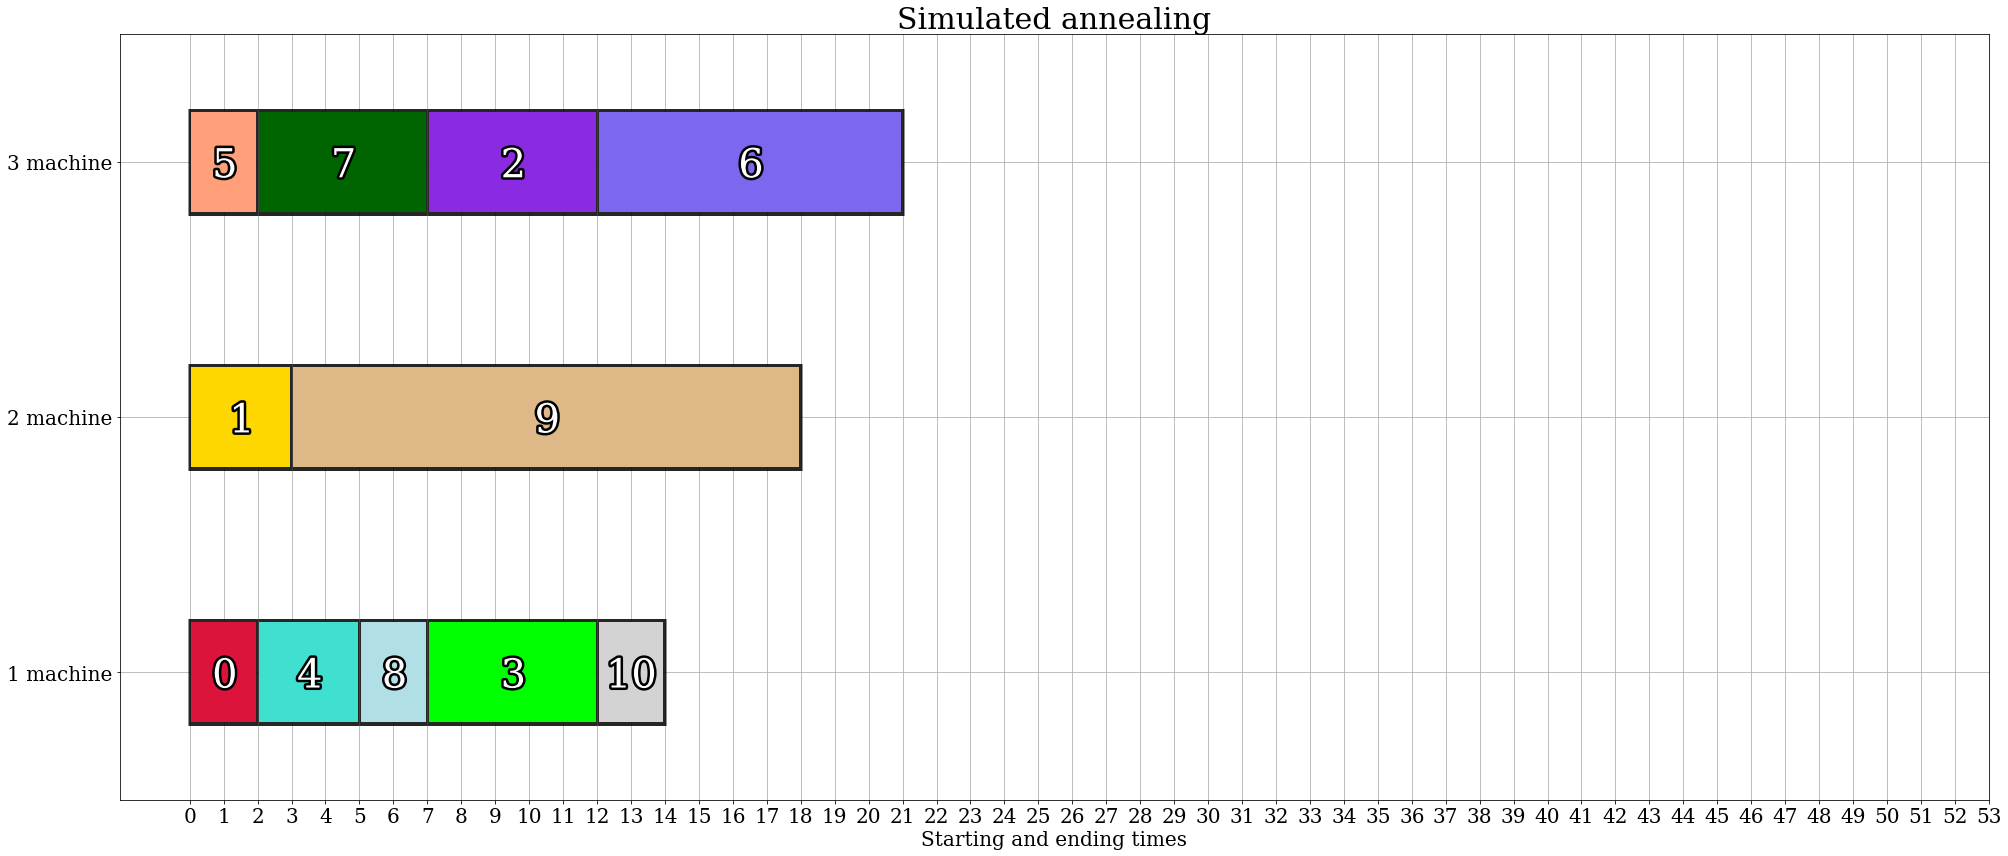

In [19]:
order_result, solution_result, objective_function_value_result, objective_function_values, total_number_of_iterations = generating_new_solution(starting_solution, order, starting_objective_function_value, T=50, alpha=0.9, epochs=5, stages=20, max_iterations_without_improvement=4, number_of_tasks=6)

In [ ]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (20, 10))
camera_2 = Camera(fig)
i_s = []
vals = []
for i, value in enumerate(objective_function_values):
    i_s += [i]
    vals += [value]
    ax.plot(i_s, vals, color='#FF7F50')
    ax.set_title("Objective function value's history", fontsize=30)
    ax.set_xlabel('Number of iteration', fontsize=20)
    ax.set_ylabel('Value', fontsize=20)
    ax.set_xticks(np.linspace(0, total_number_of_iterations, 10))
    ax.grid(True)
    plt.tight_layout()

    camera_2.snap()
animation2 = camera_2.animate()
animation2.save('animation_test.mp4')

In [21]:
import plotly.express as px  # ........ conda install plotly 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [22]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(y=objective_function_values, mode="lines"), row=1, col=1)

fig.show()